In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

['00', '01', '04', '05', '06', '08', '09', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '23', '24', '26', '28', '29', '30', '31', '33', '35', '37', '38', '41', '42', '43', '44', '45', '50', '51', '53', '54', '56', '59', '60', '62', '63', '65', '69', '70', '72', '74', '75', '76', '77', '79', '81', '82', '84', '85', '87', '88', '89', '90', '91', '94', '95', '97', '98']
Dataset CustomImageFolder
    Number of datapoints: 64000
    Root location: double_mnist/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
['03', '07', '10', '22', '27', '34', '39', '40', '48', '52', '58', '61', '64', '71', '93', '99']
tensor([23, 41,  9, 79, 82, 19, 62, 24, 50,  1, 72, 65, 70, 81, 33, 77, 15, 24,
        75,  5, 43, 35, 19, 16, 15,  9, 59, 41, 29, 79, 91, 87, 81, 24,

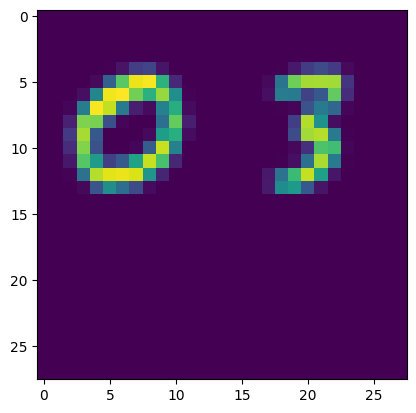

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if not already
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data_path = 'double_mnist/train'
val_data_path = 'double_mnist/val'
test_data_path = 'double_mnist/test'
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # Assign labels based on folder name
        folder_name = os.path.basename(os.path.dirname(path))
        return sample, int(folder_name)  # Convert the folder name to an integer label
# Create ImageFolder datasets for training, validation, and test sets
train_dataset = CustomImageFolder(train_data_path, transform=transform)
val_dataset = CustomImageFolder(val_data_path, transform=transform)
test_dataset = CustomImageFolder(test_data_path, transform=transform)
print(train_dataset.classes)
class_to_label = {str(i).zfill(2): i for i in range(100)}
# Define batch sizes
batch_size = 64
print(train_dataset)
# Create DataLoader instances for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of classes
num_classes = 10

class_names = train_dataset.classes
class_names = val_dataset.classes

print(class_names)

for images, labels in train_loader:
    print(labels)
    break
for images, labels in val_loader:
    plt.imshow(images[0].permute(1, 2, 0))
    print(labels[0])
    print(labels)
    break




In [8]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=128, dropout_rate=0.5):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

# Define the model
input_size = 28 * 28  # Replace with the actual input size
num_classes = 10  # Replace with the actual number of classes
hidden_size = 128
dropout_rate = 0.5

model = SimpleMLP(input_size, num_classes, hidden_size, dropout_rate)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model1 = SimpleMLP(input_size, num_classes, hidden_size, dropout_rate)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)





In [9]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    cnt = 0
    for images, labels in train_loader:
        labels1 = labels//10
        labels2 = labels%10
        optimizer1.zero_grad()
        optimizer.zero_grad()
        image = images.clone()
        image1 = images.clone()
        left_half = images[:, :, :, :images.shape[3] // 2]
        image[:, :, :, (image.shape[3] // 2):] = left_half
        right_half = images[:, :, :, images.shape[3] // 2 :]
        image1[:, :, :, :(image1.shape[3] // 2)] = right_half
        outputs = model(image)
        outputs1 = model1(image1)
        loss = criterion(outputs, labels1)
        loss1 = criterion1(outputs1,labels2)
        loss.backward()
        loss1.backward()
        optimizer.step()
        optimizer1.step()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, predicted1 = torch.max(outputs1.data, 1)
        total_train += 2*labels.size(0)
        for i in range(labels.size(0)):
            if(predicted[i] == labels[i]//10):
                correct_train += 1
            if(predicted1[i] == labels[i]%10):
                correct_train += 1
    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
    model.eval()
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in val_loader:
            labels1 = labels // 10
            labels2 = labels % 10
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_val += 2*labels.size(0)
            for i in range(labels.size(0)):
                if(predicted[i] == labels[i]//10):
                    correct_val += 1
                if(predicted1[i] == labels[i]%10):
                    correct_val += 1
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Loss: {average_val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%')
    model.eval()
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels1 = labels // 10
            labels2 = labels % 10
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_val += 2*labels.size(0)
            for i in range(labels.size(0)):
                if(predicted[i] == labels[i]//10):
                    correct_val += 1
                if(predicted1[i] == labels[i]%10):
                    correct_val += 1
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')


Epoch 1/25 - Train Loss: 1.8908 - Train Accuracy: 32.95%
Epoch 1/25 - Validation Loss: 1.8996 - Validation Accuracy: 35.45%
Epoch 1/25 - Testing Loss: 1.9650 - Testing Accuracy: 23.30%
Epoch 2/25 - Train Loss: 1.7160 - Train Accuracy: 40.19%
Epoch 2/25 - Validation Loss: 1.7667 - Validation Accuracy: 40.88%
Epoch 2/25 - Testing Loss: 1.7973 - Testing Accuracy: 31.55%
Epoch 3/25 - Train Loss: 1.5408 - Train Accuracy: 48.11%
Epoch 3/25 - Validation Loss: 1.5268 - Validation Accuracy: 50.45%
Epoch 3/25 - Testing Loss: 1.5913 - Testing Accuracy: 39.88%
Epoch 4/25 - Train Loss: 1.3430 - Train Accuracy: 55.78%
Epoch 4/25 - Validation Loss: 1.3794 - Validation Accuracy: 54.42%
Epoch 4/25 - Testing Loss: 1.3984 - Testing Accuracy: 49.34%
Epoch 5/25 - Train Loss: 1.1846 - Train Accuracy: 60.82%
Epoch 5/25 - Validation Loss: 1.1264 - Validation Accuracy: 62.33%
Epoch 5/25 - Testing Loss: 1.1948 - Testing Accuracy: 54.24%
Epoch 6/25 - Train Loss: 1.0752 - Train Accuracy: 63.99%
Epoch 6/25 - Valid

In [58]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    cnt = 0
    for images, labels in train_loader:
        labels1 = labels//10
        # class_names = train_dataset.classes
        optimizer.zero_grad()
        image = images.clone()
        left_half = images[:, :, :, :images.shape[3] // 2]
        # print(left_half.shape)
        image[:, :, :, (image.shape[3] // 2):] = left_half
        # print(images.shape)
        outputs = model(image)
        loss = criterion(outputs, labels1)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        for i in range(labels.size(0)):
            if(predicted[i] == labels1[i]):
                correct_train += 1
        # cnt += 1
        # if(cnt == 10):
        #     break
    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in val_loader:
            labels1 = labels // 10
            image = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            outputs = model(image)
            loss = criterion(outputs, labels1)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels1).sum().item()
            cnt += 1
            # if(cnt == 10):
            #     print(predicted)
            #     print(labels1)
            #     print(labels)
            #     break
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Loss: {average_val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%')
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels1 = labels // 10
            image = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            outputs = model(image)
            loss = criterion(outputs, labels1)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels1).sum().item()
            cnt += 1
            # if(cnt == 10):
            #     print(predicted)
            #     print(labels1)
            #     print(labels)
            #     break
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')


Epoch 1/5 - Train Loss: 0.1171 - Train Accuracy: 96.44%
Epoch 1/5 - Validation Loss: 0.0829 - Validation Accuracy: 97.42%
Epoch 1/5 - Testing Loss: 0.0991 - Testing Accuracy: 97.00%
Epoch 2/5 - Train Loss: 0.1029 - Train Accuracy: 96.87%
Epoch 2/5 - Validation Loss: 0.0755 - Validation Accuracy: 97.78%
Epoch 2/5 - Testing Loss: 0.0821 - Testing Accuracy: 97.47%
Epoch 3/5 - Train Loss: 0.0926 - Train Accuracy: 97.21%
Epoch 3/5 - Validation Loss: 0.0868 - Validation Accuracy: 97.53%
Epoch 3/5 - Testing Loss: 0.0810 - Testing Accuracy: 97.75%
Epoch 4/5 - Train Loss: 0.0836 - Train Accuracy: 97.35%
Epoch 4/5 - Validation Loss: 0.0753 - Validation Accuracy: 97.86%
Epoch 4/5 - Testing Loss: 0.0861 - Testing Accuracy: 97.48%
Epoch 5/5 - Train Loss: 0.0785 - Train Accuracy: 97.52%
Epoch 5/5 - Validation Loss: 0.0758 - Validation Accuracy: 97.85%
Epoch 5/5 - Testing Loss: 0.0923 - Testing Accuracy: 97.39%


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    cnt = 0
    for images, labels in train_loader:
        labels1 = labels % 10
        # class_names = train_dataset.classes
        optimizer.zero_grad()
        image = images.clone()
        left_half = images[:, :, :, images.shape[3] // 2:]
        # print(left_half.shape)
        image[:, :, :, :(image.shape[3] // 2)] = left_half
        # print(images.shape)
        outputs = model(image)
        loss = criterion(outputs, labels1)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        for i in range(labels.size(0)):
            if(predicted[i] == labels1[i]):
                correct_train += 1
        # cnt += 1
        # if(cnt == 10):
        #     break
    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in val_loader:
            labels1 = labels % 10
            image = images.clone()
            left_half = images[:, :, :, images.shape[3] // 2:]
            image[:, :, :, :(image.shape[3] // 2)] = left_half
            outputs = model(image)
            loss = criterion(outputs, labels1)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels1).sum().item()
            cnt += 1
            # if(cnt == 10):
            #     print(predicted)
            #     print(labels1)
            #     print(labels)
            #     break
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Loss: {average_val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%')
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels1 = labels % 10
            image = images.clone()
            left_half = images[:, :, :, images.shape[3] // 2:]
            image[:, :, :, :(image.shape[3] // 2)] = left_half
            outputs = model(image)
            loss = criterion(outputs, labels1)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels1).sum().item()
            cnt += 1
            # if(cnt == 10):
            #     print(predicted)
            #     print(labels1)
            #     print(labels)
            #     break
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')


Epoch 1/3 - Train Loss: 0.1110 - Train Accuracy: 96.71%
Epoch 1/3 - Validation Loss: 0.0776 - Validation Accuracy: 97.67%
Epoch 1/3 - Testing Loss: 0.0646 - Testing Accuracy: 97.91%
Epoch 2/3 - Train Loss: 0.0867 - Train Accuracy: 97.27%
Epoch 2/3 - Validation Loss: 0.0762 - Validation Accuracy: 97.79%
Epoch 2/3 - Testing Loss: 0.0794 - Testing Accuracy: 97.61%
Epoch 3/3 - Train Loss: 0.0784 - Train Accuracy: 97.59%
Epoch 3/3 - Validation Loss: 0.0668 - Validation Accuracy: 98.06%
Epoch 3/3 - Testing Loss: 0.0618 - Testing Accuracy: 97.95%
